In [102]:
%reload_ext autoreload
%autoreload 2
import tensorflow as tf
import sys
import math
import numpy as np
sys.path.append('../../pytools')
import d2l

d2l.gpu_mem_init()

Memory growth enabled for PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'): True


In [103]:
class ConvBlock(tf.keras.layers.Layer):
    def __init__(self, num_channels):
        super(ConvBlock, self).__init__()
        self.bn = tf.keras.layers.BatchNormalization()
        self.relu = tf.keras.layers.ReLU()
        self.conv = tf.keras.layers.Conv2D(filters=num_channels, kernel_size=3, padding='same')
        self.list_layers = [self.bn, self.relu, self.conv]

    def call(self, X):
        Y = X
        for layer in self.list_layers:
            Y = layer(Y)
        y = tf.keras.layers.concatenate([X, Y], axis=-1)
        return y


In [104]:
class DenseBlock(tf.keras.layers.Layer):
    def __init__(self, num_convs, num_channels):
        super(DenseBlock, self).__init__()
        self.listLayers = []
        for _ in range(num_convs):
            self.listLayers.append(ConvBlock(num_channels))

    def call(self, x):
        for layer in self.listLayers:
            x = layer(x)
        return x

In [105]:
blk = DenseBlock(2, 10)
X = tf.random.uniform((4, 8, 8, 3))
Y = blk(X)
Y.shape

TensorShape([4, 8, 8, 23])

In [106]:
class TransitionBlock(tf.keras.layers.Layer):
    def __init__(self, num_channels, **kwargs):
        super(TransitionBlock, self).__init__(**kwargs)
        self.bn = tf.keras.layers.BatchNormalization()
        self.relu = tf.keras.layers.ReLU()
        self.conv = tf.keras.layers.Conv2D(num_channels, kernel_size=1)
        self.pool = tf.keras.layers.MaxPool2D(pool_size=2, strides=2)
    def call(self, X):
        X = self.bn(X)
        X = self.relu(X)
        X = self.conv(X)
        return self.pool(X)

In [107]:
blk = TransitionBlock(10)
blk(Y).shape

TensorShape([4, 4, 4, 10])

In [108]:
def block_1():
    return tf.keras.Sequential([
       tf.keras.layers.Conv2D(64, kernel_size=7, strides=2, padding='same'),
       tf.keras.layers.BatchNormalization(),
       tf.keras.layers.ReLU(),
       tf.keras.layers.MaxPool2D(pool_size=3, strides=2, padding='same')])

In [109]:
def block_2():
    net = block_1()
    # num_channels为当前的通道数
    num_channels, growth_rate = 64, 32
    num_convs_in_dense_blocks = [4, 4, 4, 4]

    for i, num_convs in enumerate(num_convs_in_dense_blocks):
        net.add(DenseBlock(num_convs, growth_rate))
        # 上一个稠密块的输出通道数
        num_channels += num_convs * growth_rate
        # 在稠密块之间添加一个转换层，使通道数量减半
        if i != len(num_convs_in_dense_blocks) - 1:
            num_channels //= 2
            net.add(TransitionBlock(num_channels))
    return net

In [110]:
def net():
    net = block_2()
    net.add(tf.keras.layers.BatchNormalization())
    net.add(tf.keras.layers.ReLU())
    net.add(tf.keras.layers.GlobalAvgPool2D())
    net.add(tf.keras.layers.Flatten())
    net.add(tf.keras.layers.Dense(10))
    return net

loss 0.105, train acc 0.963, test acc 0.900
3466.9 examples/sec on /GPU:0


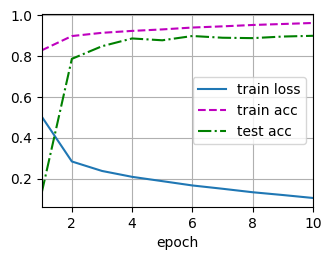

In [111]:
lr, num_epochs, batch_size = 0.1, 10, 256
train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size, resize=96)
dense_net = d2l.train_ch6(net, train_iter, test_iter, num_epochs, lr, d2l.try_gpu())

In [112]:
print(dense_net.summary())

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_59 (Conv2D)              │ (256, 48, 48, 64)      │         3,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_66          │ (256, 48, 48, 64)      │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_62 (ReLU)                 │ (256, 48, 48, 64)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (256, 24, 24, 64)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_block_29 (DenseBlock)     │ (256, 24, 24, 192)     │       130,944 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ transition_block_6              │ (256, 12, 12, 96)      │        19,296 │
│ (TransitionBlock)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_block_30 (DenseBlock)     │ (256, 12, 12, 224)     │       168,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ transition_block_7              │ (256, 6, 6, 112)       │        26,096 │
│ (TransitionBlock)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_block_31 (DenseBlock)     │ (256, 6, 6, 240)       │       187,008 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ transition_block_8              │ (256, 3, 3, 120)       │        29,880 │
│ (TransitionBlock)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_block_32 (DenseBlock)     │ (256, 3, 3, 248)       │       196,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_86          │ (256, 3, 3, 248)       │           992 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_82 (ReLU)                 │ (256, 3, 3, 248)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (256, 248)             │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (256, 248)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (256, 10)              │         2,490 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 764,836 (2.92 MB)

 Trainable params: 758,226 (2.89 MB)

 Non-trainable params: 6,608 (25.81 KB)

 Optimizer params: 2 (12.00 B)

None
